# Deep Learning Assessment
Aanuoluwapo Elizabeth Olurin
23698591

## Import Packages

In [ ]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
# Import necessary packages.
import pandas as pd
import numpy as np
import opendatasets as od
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms
import torch.profiler

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torchvision.models as models

## Dataset

In [ ]:
od.download('https://www.kaggle.com/datasets/trolukovich/food11-image-dataset/') # insert ypu kaggle username and key


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aanuoluwapoakinbode
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset


100%|██████████| 1.08G/1.08G [01:14<00:00, 15.7MB/s]


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224),  # Adjust size based on your images
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.RandomRotation(degrees=20),  # Slightly higher rotation angle
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),  # More subtle color adjustments
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Construct datasets.
original_dataset = datasets.ImageFolder("/content/food11-image-dataset")
train_dataset = datasets.ImageFolder("/content/food11-image-dataset/training", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/food11-image-dataset/evaluation", transform=test_transform)
val_dataset = datasets.ImageFolder("/content/food11-image-dataset/validation", transform=val_transform)

print(f'Original set has {len(original_dataset)} samples')
print(f'Train set has {len(train_dataset)} samples')
print(f'Test set has {len(test_dataset)} samples')
print(f'Validation set has {len(val_dataset)} samples')

# Print class-to-index mapping
print("Class-to-Index Mapping:", train_dataset.class_to_idx)

Original set has 16643 samples
Train set has 9866 samples
Test set has 3347 samples
Validation set has 3430 samples
Class-to-Index Mapping: {'Bread': 0, 'Dairy product': 1, 'Dessert': 2, 'Egg': 3, 'Fried food': 4, 'Meat': 5, 'Noodles-Pasta': 6, 'Rice': 7, 'Seafood': 8, 'Soup': 9, 'Vegetable-Fruit': 10}


In [ ]:
# Batch size for training, validation, and testing.
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

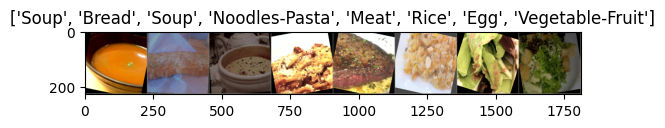

In [ ]:
# Define mean and std for normalization (should match the values used in your data transform)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean  # denormalize
    inp = np.clip(inp, 0, 1)  # clip to the valid range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
train_loader_for_vis = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']

imshow(out, title=[class_names[x] for x in classes])

## Model

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 14 * 14, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

    def forward(self, x):
        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyCNN()
model = model.to(device)

## Loss and Optimizer

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Apply L2 regularization (weight decay) and learning rate scheduling
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Initialize learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

## Train and Validation

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_min = val_loss

In [ ]:
# Initialize the early stopping object
early_stopping = EarlyStopping(patience=5, verbose=True)

# The number of training epochs.
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []



    # ---------- Training ----------
    # Make sure the model is in train mode before training.
def train_one_epoch(epoch):
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
          optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
          imgs, labels = batch
          imgs = imgs.to(device)
          labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
          logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
          loss = criterion(logits, labels)

        # Compute the gradients for parameters.
          loss.backward()

        # Initialize gradient clipping to prevent explosion
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update the parameters with computed gradients.
          optimizer.step()

        # Compute the accuracy for current batch.
          acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
          train_loss.append(loss.item())
          train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
def validate_one_epoch(epoch):
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)
     # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")
    return valid_loss, valid_acc

for epoch in range(n_epochs):
    train_one_epoch(epoch)
    val_loss, val_acc = validate_one_epoch(epoch)

    # save the best model
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), 'best_MyCNN_model.pth')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    scheduler.step(val_loss)

  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=2.72535, acc=0.17047


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 001/020] Valid: loss=2.25500, acc=0.18953
Validation loss decreased (inf --> 2.255003).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=2.24966, acc=0.19956


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 002/020] Valid: loss=2.19914, acc=0.22396
Validation loss decreased (2.255003 --> 2.199144).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=2.21901, acc=0.21371


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 003/020] Valid: loss=2.15879, acc=0.24103
Validation loss decreased (2.199144 --> 2.158795).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=2.17434, acc=0.23125


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 004/020] Valid: loss=2.11238, acc=0.24508
Validation loss decreased (2.158795 --> 2.112375).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=2.16606, acc=0.23738


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 005/020] Valid: loss=2.09608, acc=0.25116
Validation loss decreased (2.112375 --> 2.096081).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=2.13507, acc=0.23528


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 006/020] Valid: loss=2.07368, acc=0.26061
Validation loss decreased (2.096081 --> 2.073679).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=2.09530, acc=0.26064


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 007/020] Valid: loss=2.01068, acc=0.27440
Validation loss decreased (2.073679 --> 2.010682).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=2.04583, acc=0.27698


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 008/020] Valid: loss=1.90783, acc=0.33025
Validation loss decreased (2.010682 --> 1.907832).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=1.99329, acc=0.29909


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 009/020] Valid: loss=1.84736, acc=0.34674
Validation loss decreased (1.907832 --> 1.847358).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=1.95350, acc=0.31339


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 010/020] Valid: loss=1.96914, acc=0.28877
EarlyStopping counter: 1 out of 5


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=1.91901, acc=0.33081


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 011/020] Valid: loss=1.77241, acc=0.36410
Validation loss decreased (1.847358 --> 1.772409).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=1.89895, acc=0.33441


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 012/020] Valid: loss=1.76524, acc=0.38513
Validation loss decreased (1.772409 --> 1.765244).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=1.86082, acc=0.35314


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 013/020] Valid: loss=1.74174, acc=0.39950
Validation loss decreased (1.765244 --> 1.741736).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=1.84406, acc=0.35483


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 014/020] Valid: loss=1.79043, acc=0.37326
EarlyStopping counter: 1 out of 5


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=1.81687, acc=0.36646


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 015/020] Valid: loss=1.67235, acc=0.42207
Validation loss decreased (1.741736 --> 1.672345).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=1.79504, acc=0.37623


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 016/020] Valid: loss=1.71270, acc=0.41917
EarlyStopping counter: 1 out of 5


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=1.78683, acc=0.38099


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 017/020] Valid: loss=1.68565, acc=0.40548
EarlyStopping counter: 2 out of 5


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=1.76100, acc=0.38647


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 018/020] Valid: loss=1.63649, acc=0.43827
Validation loss decreased (1.672345 --> 1.636491).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=1.74466, acc=0.39134


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 019/020] Valid: loss=1.61335, acc=0.43084
Validation loss decreased (1.636491 --> 1.613354).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=1.72097, acc=0.39642


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 020/020] Valid: loss=1.60557, acc=0.43981
Validation loss decreased (1.613354 --> 1.605573).  Saving model ...


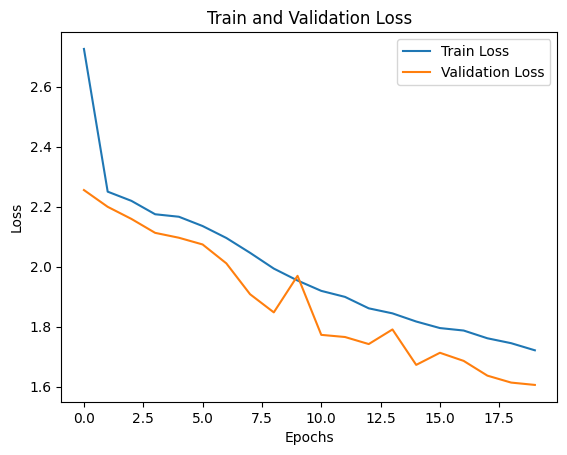

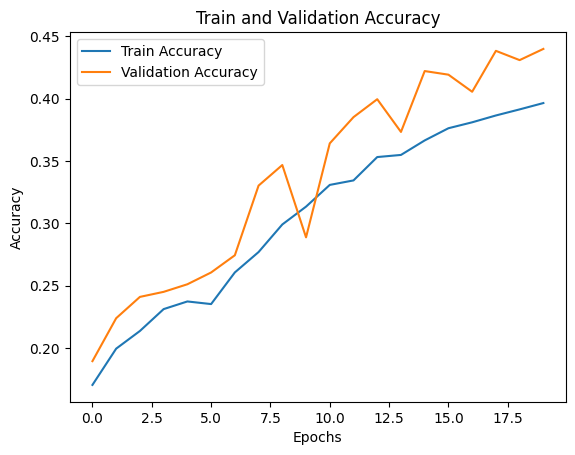

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

## Testing

  0%|          | 0/105 [00:00<?, ?it/s]

Test accuracy 0.44403195494697206
Confusion Matrix
[[ 84   1  64  45  24  91  18   1   4  18  18]
 [  2  16  59   5   6  18   0   1   5  29   7]
 [ 15   2 239   7   4 141   6   0  28  33  25]
 [ 34   1  78  67  10  44  15   1  15  32  38]
 [ 47   0  48  15  48  93   1   0   4  24   7]
 [  4   0  33   3   1 369   0   0   3   6  13]
 [ 12   0  14   9   0  13  69   2   2  15  11]
 [ 14   1  11   4   0   6  32  12   2   6   8]
 [  5   0  75   4   1 113   0   0  57   8  40]
 [  0   6  47   6   1  71   5   0   5 345  14]
 [  0   0   8   2   2  38   1   0   1   4 175]]
Classification Report
                 precision    recall  f1-score   support

          Bread       0.39      0.23      0.29       368
  Dairy product       0.59      0.11      0.18       148
        Dessert       0.35      0.48      0.41       500
            Egg       0.40      0.20      0.27       335
     Fried food       0.49      0.17      0.25       287
           Meat       0.37      0.85      0.52       432
  Noodles

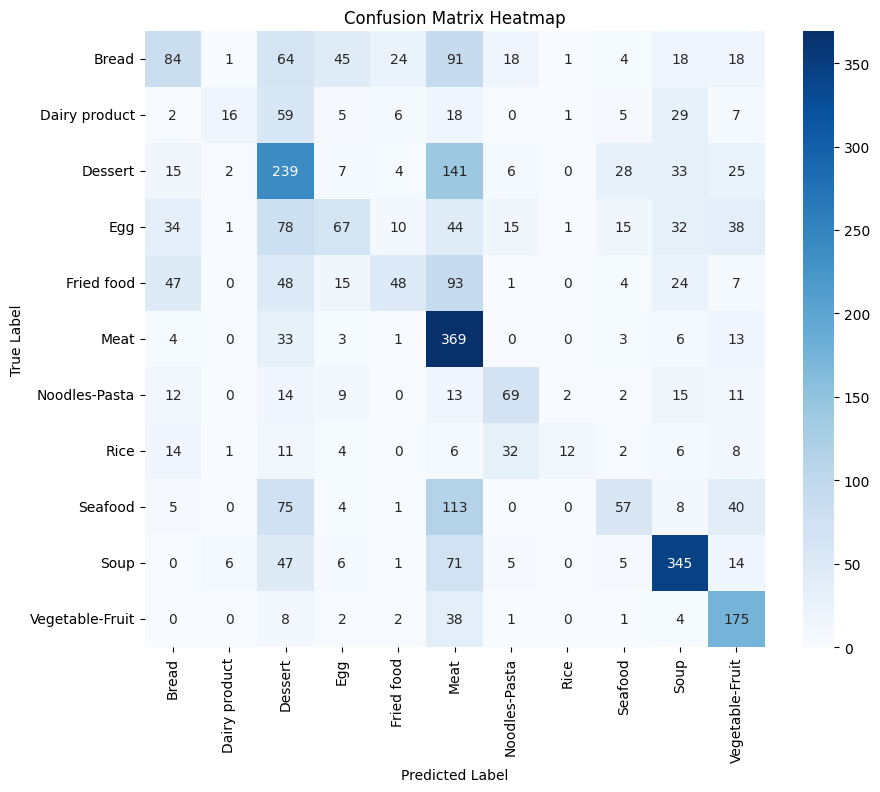

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_MyCNN_model.pth'))

model.eval()
test_accs = []
test_preds = []
test_labels = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      logits = model(imgs)

    acc = (logits.argmax(dim=-1) == labels).float().mean()
    test_accs.append(acc.item())
    test_preds.extend(logits.argmax(dim=-1).cpu().numpy())
    test_labels.extend(labels.cpu().numpy())

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

conf_matrix = confusion_matrix(test_labels, test_preds)
print('Confusion Matrix')
print(conf_matrix)

class_report = classification_report(test_labels, test_preds, target_names=train_dataset.classes)
print('Classification Report')
print(class_report)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

## DesNet121

In [ ]:
# Load pre-trained DenseNet model and modify the final layer
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 11)  # Adjust the number of classes
model = model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 89.2MB/s]


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

In [ ]:
# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Training and validation loop
n_epochs = 20
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

def train_one_epoch(epoch):
    model.train()
    train_loss = []
    train_accs = []
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc.item())
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f}")

def validate_one_epoch(epoch):
    model.eval()
    valid_loss = []
    valid_accs = []
    for batch in tqdm(valid_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(imgs)
        loss = criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")
    return valid_loss, valid_acc

for epoch in range(n_epochs):
    train_one_epoch(epoch)
    val_loss, val_acc = validate_one_epoch(epoch)
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), 'best_efficientnet_model.pth')
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    scheduler.step(val_loss)
    print(f'Learning rate after epoch {epoch + 1}: {scheduler.optimizer.param_groups[0]["lr"]}')

  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=1.47040, acc=0.51432


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 001/020] Valid: loss=1.46902, acc=0.55941
Validation loss decreased (inf --> 1.469021).  Saving model ...
Learning rate after epoch 1: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=1.21255, acc=0.60121


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 002/020] Valid: loss=1.11103, acc=0.64979
Validation loss decreased (1.469021 --> 1.111026).  Saving model ...
Learning rate after epoch 2: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=1.11334, acc=0.63633


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 003/020] Valid: loss=1.01136, acc=0.65500
Validation loss decreased (1.111026 --> 1.011361).  Saving model ...
Learning rate after epoch 3: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=1.07443, acc=0.64219


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 004/020] Valid: loss=0.98991, acc=0.69695
Validation loss decreased (1.011361 --> 0.989908).  Saving model ...
Learning rate after epoch 4: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=1.02742, acc=0.65916


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 005/020] Valid: loss=0.98163, acc=0.66908
Validation loss decreased (0.989908 --> 0.981626).  Saving model ...
Learning rate after epoch 5: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=0.97746, acc=0.67364


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 006/020] Valid: loss=1.07775, acc=0.66696
EarlyStopping counter: 1 out of 5
Learning rate after epoch 6: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=0.95726, acc=0.68347


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 007/020] Valid: loss=0.86601, acc=0.71779
Validation loss decreased (0.981626 --> 0.866008).  Saving model ...
Learning rate after epoch 7: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=0.93368, acc=0.68916


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 008/020] Valid: loss=1.06123, acc=0.64660
EarlyStopping counter: 1 out of 5
Learning rate after epoch 8: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=0.91262, acc=0.69976


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 009/020] Valid: loss=0.82575, acc=0.73090
Validation loss decreased (0.866008 --> 0.825751).  Saving model ...
Learning rate after epoch 9: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=0.87833, acc=0.70930


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 010/020] Valid: loss=0.74150, acc=0.76042
Validation loss decreased (0.825751 --> 0.741495).  Saving model ...
Learning rate after epoch 10: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=0.85036, acc=0.71903


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 011/020] Valid: loss=0.86533, acc=0.72097
EarlyStopping counter: 1 out of 5
Learning rate after epoch 11: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=0.85340, acc=0.72025


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 012/020] Valid: loss=0.72793, acc=0.76177
Validation loss decreased (0.741495 --> 0.727934).  Saving model ...
Learning rate after epoch 12: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=0.83256, acc=0.72668


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 013/020] Valid: loss=0.75023, acc=0.75916
EarlyStopping counter: 1 out of 5
Learning rate after epoch 13: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=0.82673, acc=0.73366


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 014/020] Valid: loss=0.73583, acc=0.76726
EarlyStopping counter: 2 out of 5
Learning rate after epoch 14: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=0.80228, acc=0.73412


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 015/020] Valid: loss=0.67810, acc=0.78144
Validation loss decreased (0.727934 --> 0.678098).  Saving model ...
Learning rate after epoch 15: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=0.79585, acc=0.73801


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 016/020] Valid: loss=0.73541, acc=0.76553
EarlyStopping counter: 1 out of 5
Learning rate after epoch 16: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=0.78862, acc=0.74252


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 017/020] Valid: loss=0.78399, acc=0.74595
EarlyStopping counter: 2 out of 5
Learning rate after epoch 17: 0.001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=0.75671, acc=0.74966


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 018/020] Valid: loss=0.69795, acc=0.77913
EarlyStopping counter: 3 out of 5
Learning rate after epoch 18: 0.0001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=0.63805, acc=0.78900


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 019/020] Valid: loss=0.50851, acc=0.83816
Validation loss decreased (0.678098 --> 0.508512).  Saving model ...
Learning rate after epoch 19: 0.0001


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=0.57675, acc=0.81315


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 020/020] Valid: loss=0.48108, acc=0.84973
Validation loss decreased (0.508512 --> 0.481084).  Saving model ...
Learning rate after epoch 20: 0.0001


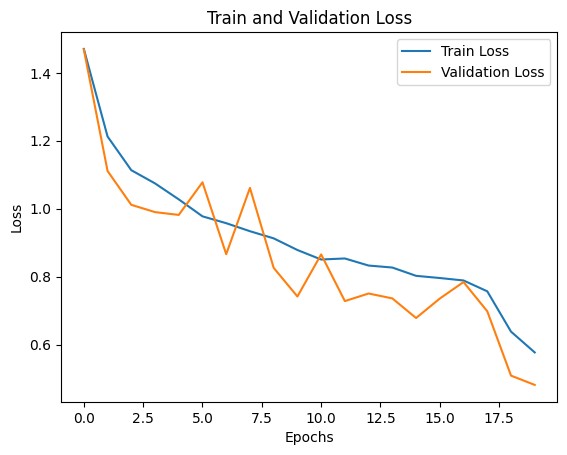

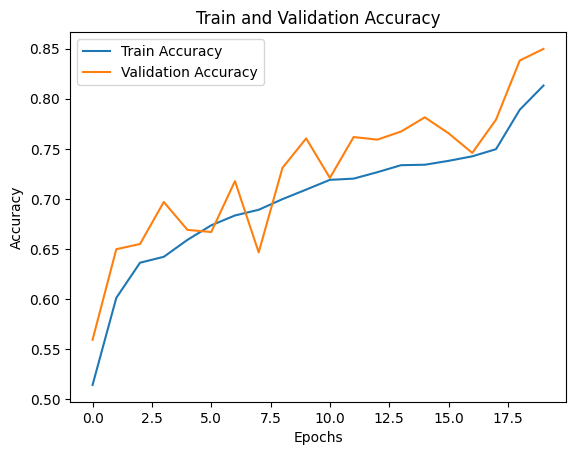

In [ ]:
# Plot the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

  0%|          | 0/105 [00:00<?, ?it/s]

Test accuracy 0.8614974935849508
Confusion Matrix
[[283   9  21  15  17  15   1   0   3   2   2]
 [  2 108  24   3   2   2   0   1   2   1   3]
 [ 15  17 382  13   9  19   3   1  14  17  10]
 [ 17   1  18 279   4   7   2   1   3   3   0]
 [  6   3  11   3 248   9   0   0   1   3   3]
 [  8   0   6   9  12 388   0   0   7   2   0]
 [  1   0   0   0   0   0 145   1   0   0   0]
 [  0   0   2   0   0   2   4  88   0   0   0]
 [  7   0   8   1   1   8   0   1 271   1   5]
 [  2   0   7   2   7   0   2   0   3 477   0]
 [  1   0   5   2   0   3   2   0   4   0 214]]
Classification Report
                 precision    recall  f1-score   support

          Bread       0.83      0.77      0.80       368
  Dairy product       0.78      0.73      0.76       148
        Dessert       0.79      0.76      0.78       500
            Egg       0.85      0.83      0.84       335
     Fried food       0.83      0.86      0.84       287
           Meat       0.86      0.90      0.88       432
  Noodles-

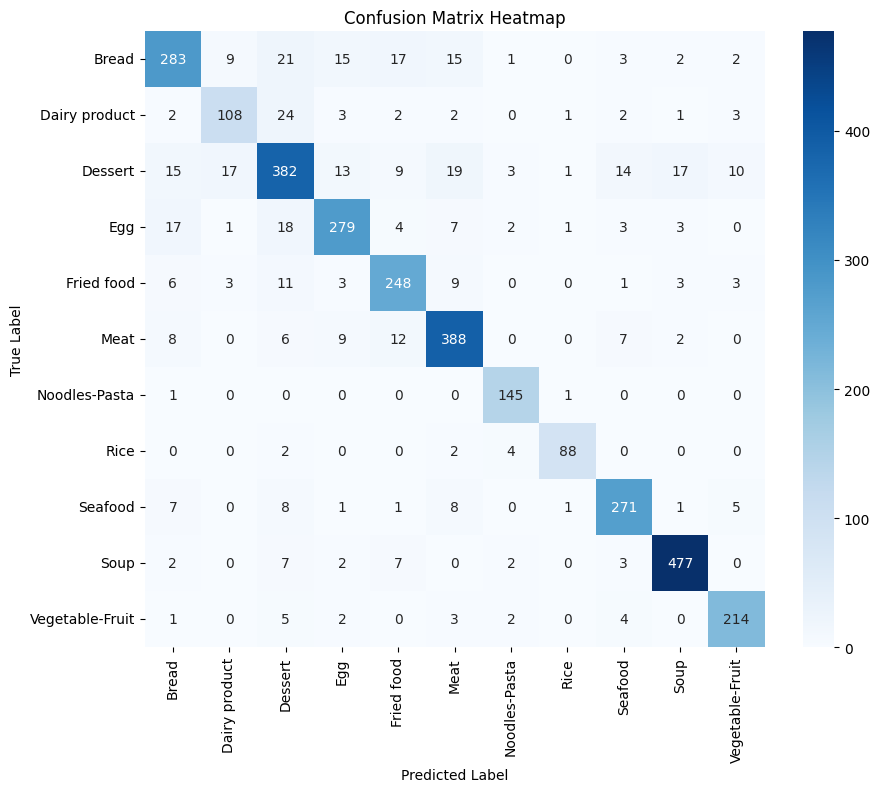

In [ ]:
# Load best model weights
model.load_state_dict(torch.load('best_efficientnet_model.pth'))

# Evaluate on test set
model.eval()
test_accs = []
test_preds = []
test_labels = []
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        logits = model(imgs)
    acc = (logits.argmax(dim=-1) == labels).float().mean()
    test_accs.append(acc.item())
    test_preds.extend(logits.argmax(dim=-1).cpu().numpy())
    test_labels.extend(labels.cpu().numpy())
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
print('Confusion Matrix')
print(conf_matrix)

# Generate classification report
class_report = classification_report(test_labels, test_preds, target_names=train_dataset.classes)
print('Classification Report')
print(class_report)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

## ResNet50

In [ ]:
# Transfer learning example with ResNet
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to match the number of classes
num_classes = 11  # Update this to match your dataset's number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the specified device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_min = val_loss

In [ ]:
def train_one_epoch(epoch):
    model.train()
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f}")

def validate_one_epoch(epoch):
    model.eval()
    valid_loss = []
    valid_accs = []

    for batch in tqdm(valid_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(imgs)
        loss = criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")
    return valid_loss, valid_acc

n_epochs = 20
early_stopping = EarlyStopping(patience=5, verbose=True)
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):
    train_one_epoch(epoch)
    val_loss, val_acc = validate_one_epoch(epoch)

    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet50_model.pth')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    scheduler.step(val_loss)

  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=1.90021, acc=0.35030


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 001/020] Valid: loss=1.61619, acc=0.45370
Validation loss decreased (inf --> 1.616187).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=1.57061, acc=0.46561


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 002/020] Valid: loss=1.36571, acc=0.54138
Validation loss decreased (1.616187 --> 1.365712).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=1.45088, acc=0.51080


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 003/020] Valid: loss=1.50855, acc=0.50424
EarlyStopping counter: 1 out of 5


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=1.36280, acc=0.54521


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 004/020] Valid: loss=1.31632, acc=0.58391
Validation loss decreased (1.365712 --> 1.316324).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=1.29506, acc=0.56717


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 005/020] Valid: loss=1.16930, acc=0.61458
Validation loss decreased (1.316324 --> 1.169300).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=1.26758, acc=0.57828


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 006/020] Valid: loss=1.26502, acc=0.58787
EarlyStopping counter: 1 out of 5


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=1.19936, acc=0.59848


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 007/020] Valid: loss=1.34191, acc=0.55864
EarlyStopping counter: 2 out of 5


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=1.18647, acc=0.60625


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 008/020] Valid: loss=1.25131, acc=0.59751
EarlyStopping counter: 3 out of 5


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=1.00213, acc=0.66638


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 009/020] Valid: loss=0.81477, acc=0.73573
Validation loss decreased (1.169300 --> 0.814768).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=0.92263, acc=0.69610


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 010/020] Valid: loss=0.77230, acc=0.74826
Validation loss decreased (0.814768 --> 0.772296).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=0.89403, acc=0.70736


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 011/020] Valid: loss=0.77846, acc=0.73293
EarlyStopping counter: 1 out of 5


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=0.88060, acc=0.71110


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 012/020] Valid: loss=0.75661, acc=0.74537
Validation loss decreased (0.772296 --> 0.756611).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=0.87107, acc=0.71155


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 013/020] Valid: loss=0.75960, acc=0.74817
EarlyStopping counter: 1 out of 5


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=0.83958, acc=0.72271


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 014/020] Valid: loss=0.72559, acc=0.75723
Validation loss decreased (0.756611 --> 0.725587).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=0.82860, acc=0.72514


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 015/020] Valid: loss=0.71078, acc=0.76591
Validation loss decreased (0.725587 --> 0.710780).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=0.81661, acc=0.73469


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 016/020] Valid: loss=0.69644, acc=0.77257
Validation loss decreased (0.710780 --> 0.696443).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=0.80200, acc=0.73258


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 017/020] Valid: loss=0.69059, acc=0.77286
Validation loss decreased (0.696443 --> 0.690588).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=0.79149, acc=0.73855


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 018/020] Valid: loss=0.67716, acc=0.77662
Validation loss decreased (0.690588 --> 0.677156).  Saving model ...


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=0.77927, acc=0.74221


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 019/020] Valid: loss=0.70231, acc=0.76900
EarlyStopping counter: 1 out of 5


  0%|          | 0/309 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=0.75642, acc=0.74739


  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 020/020] Valid: loss=0.69187, acc=0.76630
EarlyStopping counter: 2 out of 5


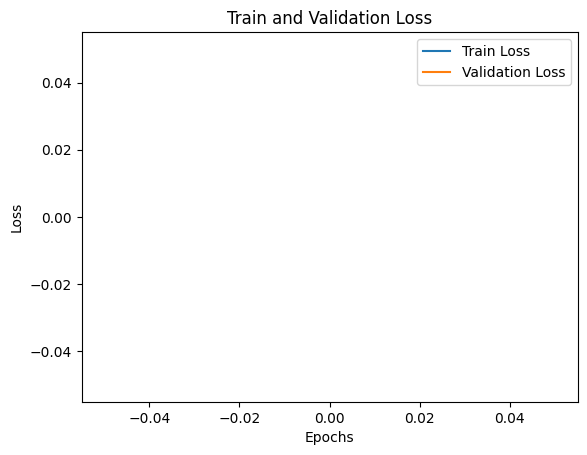

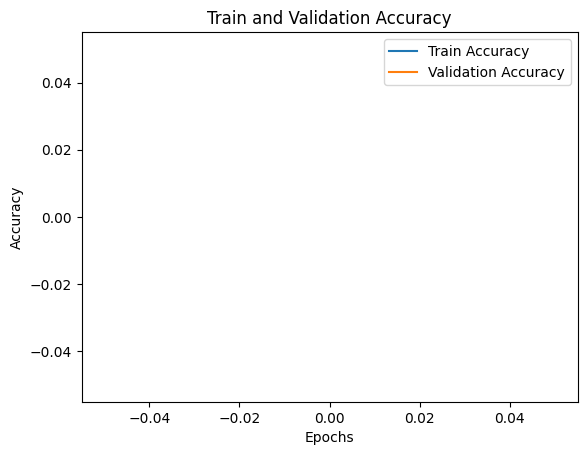

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

  0%|          | 0/105 [00:00<?, ?it/s]

Test accuracy 0.8024749375524975
Confusion Matrix
[[224   4  29  32  33  17   1   1  16  10   1]
 [  3  72  46   6   4   2   1   0   7   3   4]
 [  7  20 368  14  14   9   5   1  27  22  13]
 [ 28   3  11 248  13   2   9   0  13   8   0]
 [  2   0  11   8 241   5   2   0   7   7   4]
 [ 13   1  13  12  18 357   4   1   9   3   1]
 [  1   0   0   0   0   0 142   0   3   1   0]
 [  0   0   1   0   0   1   3  89   0   2   0]
 [  3   0  11   4   0   3   4   1 266   6   5]
 [  1   0   7   5   3   2   4   2   7 468   1]
 [  0   2   7   6   0   2   1   0   4   0 209]]
Classification Report
                 precision    recall  f1-score   support

          Bread       0.79      0.61      0.69       368
  Dairy product       0.71      0.49      0.58       148
        Dessert       0.73      0.74      0.73       500
            Egg       0.74      0.74      0.74       335
     Fried food       0.74      0.84      0.79       287
           Meat       0.89      0.83      0.86       432
  Noodles-

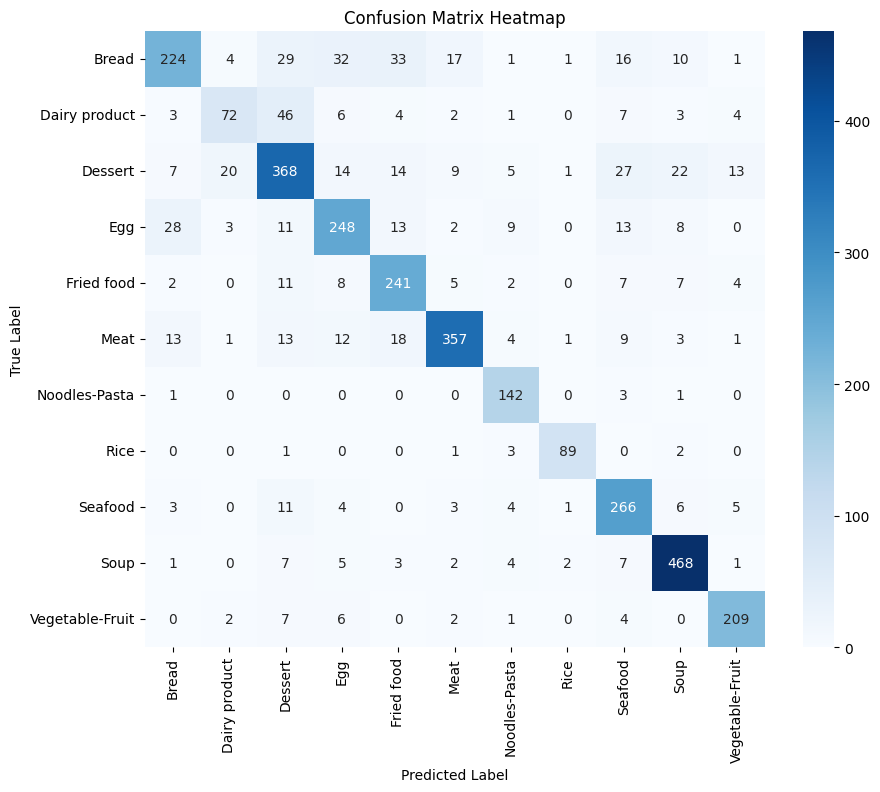

In [ ]:
model.load_state_dict(torch.load('best_resnet50_model.pth'))
model.eval()
test_accs = []
test_preds = []
test_labels = []

for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        logits = model(imgs)
    acc = (logits.argmax(dim=-1) == labels).float().mean()
    test_accs.append(acc.item())
    test_preds.extend(logits.argmax(dim=-1).cpu().numpy())
    test_labels.extend(labels.cpu().numpy())

test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

conf_matrix = confusion_matrix(test_labels, test_preds)
print('Confusion Matrix')
print(conf_matrix)

class_report = classification_report(test_labels, test_preds, target_names=train_dataset.classes)
print('Classification Report')
print(class_report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()